# Examining new dataset from Zimmer lab

In this notebook, we examine a new fluorescent microscopy dataset recorded by Manuel Zimmer's lab.

Zimmer lab homepage: <https://www.imp.ac.at/groups/manuel-zimmer/>

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [3]:
import h5py
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

from otimage.viewers import ImageSliceViewer3D
from otimage.utils import make_movie

### Load mCherry dataset from file

This dataset is 28 GB in size, so we need to be careful how much of it we try to load at once. 

#### Spec (copied from `README.md` file in Dropbox folder):

- Dataset Name: 'mCherry'
- No. of dimensions: 5 (v, c, z, y, x)
- Dimension Sizes: (1516, 1, 33, 650, 890)
- Max Dim. Size: (1516, 1, 33, 650, 890)
- Data Type: uint16
- Layout: CHUNKED (1, 1, 33, 650, 890)
- Compression: LZF
- Attributes:
  - 'elementsizeum': 3-element float64 array (µm) (z, y, x)


In [5]:
IN_FPATH = '/home/mn2822/Desktop/WormOT/data/zimmer/mCherry_v00065-01581.hdf5'

with h5py.File(IN_FPATH, 'r') as f:
    
    dset = f.get('mCherry')
    units = dset.attrs['element_size_um']
    
    frame = dset[500, 0, :, :, :]
    frame = np.moveaxis(frame, [0, 1, 2], [2, 1, 0])

### Unit sizes (microns)

**TODO: Figure out why these dimensions don't make sense**

In [6]:
print(f'X: {units[2]}\nY: {units[1]}\nZ: {units[0]}')

X: 6.45
Y: 6.45
Z: 1.0


### Plot max. projection of zoomed-in head

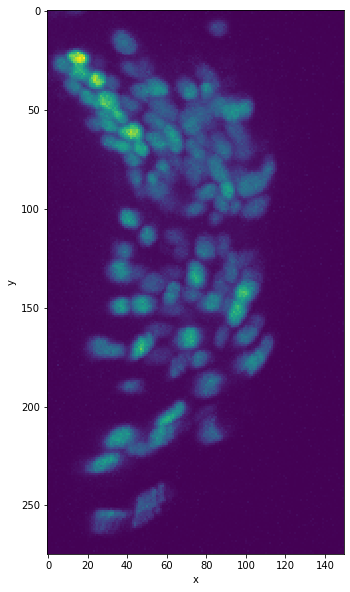

In [7]:
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]

plt.figure(figsize=(10, 10))
plt.imshow(np.max(img, 2).T);
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('zimmer_1.png')

### Use slice viewer to look at 3D structure of head image

In [8]:
ImageSliceViewer3D(np.swapaxes(img, 0, 1));

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

### Create videos of max-projected worm motion

#### Parameters

In [9]:
t_start = 0
t_end = 10
threshold = 250

#### Get max- and argmax-projected frames

In [10]:
with h5py.File(IN_FPATH, 'r') as f:
    
    dset = f.get('mCherry')
    
    frames_mp = []
    frames_am = []
   
    for t in range(t_start, t_end):
        
        frame = dset[t, 0, :, :, :]
        
        # Compute max projection
        mp_frame = np.max(frame, 0)
        frames_mp.append(mp_frame)
        
        # Compute 'argmax projection'
        am_frame = np.argmax(frame, 0)
        am_frame[mp_frame < threshold] = 0
        frames_am.append(am_frame)

### Create max-projected video

In [11]:
# Create animation
fig = plt.figure()
ani = make_movie(frames_mp, fig)
plt.axis('off')
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())

#ani.save('zimmer_maxproj.mp4', fps=10)

### Create max-projected video with color-coded depth

In [12]:
# Create animation
fig = plt.figure()
ani = make_movie(frames_am, fig)
plt.axis('off')
plt.colorbar()
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())

#ani.save('zimmer_mp_color.mp4', fps=10)